In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import numpy as np
import os
import pandas as pd

In [2]:
srcdir = f'{os.getcwd()}/pod2_first_experiment/'
# srcdir = f'{os.getcwd()}/pod2_step_experiment/'
colors = ['red', 'blue', 'lime', 'orange']

In [3]:
def open_csv(filename):
    content = pd.read_csv(srcdir + filename, parse_dates=['time'])
    content = content.interpolate(method='linear', limit_direction='both') # replace nan
    return content

def num(integer):
    return str(integer+1).zfill(2)

class CSVresult:
    def __init__(self):
        self.ids = []
        self.racks = [open_csv(f'sensor_strips_racks_{num(i)}_to_{num(i+2)}.csv') for i in range(0, 12, 3)]
        self.coolers = [open_csv(f'cooler_fan_temperature{num(i)}.csv') for i in range(0, 4)]
        for i in range(0, 4):
            max_q = 2.18
            df = self.coolers[i]
            dfQ = open_csv(f'cooler_fan_signal{num(i)}.csv')
            df.insert(loc=1, column='mass_flow', value=dfQ['signal_default'] / 100 * max_q)
            df.name = f'P02HDZ{num(i)}'
        for i in range(0, 12, 3):
            self.racks[int(i/3)].name = f'sensor_strips_racks_{num(i)}_to_{num(i+2)}.csv'
            self.racks[int(i/3)]['realpower_sum'] = (open_csv(f'power_rack{num(i)}.csv').sum(axis=1) +
                open_csv(f'power_rack{num(i+1)}.csv').sum(axis=1) +
                open_csv(f'power_rack{num(i+2)}.csv').sum(axis=1)) / 1000
        self.racks[0]['none'] = np.nan
        self.racks[1]['none'] = np.nan
        self.racks[2]['none'] = np.nan
        self.racks[3]['none'] = np.nan

    def add(self, results, id):
        self.ids += [id]
        for i in range(0, 4):
            self.coolers[i][f'sim{id}_discharge'] = results[f'P02HDZ{num(i)}_out_T']
            self.coolers[i][f'sim{id}_return0'] = results[f'P02HDZ{num(i)}_in_T']
            self.coolers[i][f'sim{id}_mass_flow'] = results[f'P02HDZ{num(i)}_out_Q']
        for i in range(0, 12, 3):
            self.racks[int(i/3)][f'sim{id}_temperature_front_top'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_t_T']
            self.racks[int(i/3)][f'sim{id}_temperature_front_middle'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_m_T']
            self.racks[int(i/3)][f'sim{id}_temperature_front_bottom'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_in_b_T']
            self.racks[int(i/3)][f'sim{id}_temperature_rear_top'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_t_T']
            self.racks[int(i/3)][f'sim{id}_temperature_rear_middle'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_m_T']
            self.racks[int(i/3)][f'sim{id}_temperature_rear_bottom'] = results[f'sensors_racks_{num(i)}_to_{num(i+2)}_out_b_T']

    def plot_cooler(self, coolerIdx):
        xaxis = 'time'
        yaxis_real = ['mass_flow', 'discharge', 'return0']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = [f'sim{id}_mass_flow', f'sim{id}_discharge', f'sim{id}_return0']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        for a in ax:
            a.set_ylim((10, 49))
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_ylim((0, 3))
        ax[0].set_title(self.coolers[coolerIdx].name)
        ax[0].set_ylabel('Flow (m³/s)')
        ax[1].set_ylabel('Discharge (°C)')
        ax[2].set_ylabel('Return (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.coolers[coolerIdx], xaxis, yaxes, ax, labels

    def plot_rack(self, rackIdx):
        xaxis = 'time'
        yaxis_real = ['realpower_sum',
                'temperature_front_top',
                'temperature_front_middle',
                'temperature_front_bottom',
                'temperature_rear_top',
                'temperature_rear_middle',
                'temperature_rear_bottom']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = ['none',
                    f'sim{id}_temperature_front_top',
                    f'sim{id}_temperature_front_middle',
                    f'sim{id}_temperature_front_bottom',
                    f'sim{id}_temperature_rear_top',
                    f'sim{id}_temperature_rear_middle',
                    f'sim{id}_temperature_rear_bottom']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(7, 1, figsize=(8, 16), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        # if max(self.racks[rackIdx]['realpower_sum']) - min(self.racks[rackIdx]['realpower_sum']) < 0.1:
        #     ax[0].set_ylim((0, 10))
        for a in ax[1:]:
            a.set_ylim((10, 59))
        for a in ax:
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_title(self.racks[rackIdx].name)
        ax[0].set_ylabel('Power (kW)')
        ax[1].set_ylabel('Front Top (°C)')
        ax[2].set_ylabel('Front Mid (°C)')
        ax[3].set_ylabel('Front Bottom (°C)')
        ax[4].set_ylabel('Back Top (°C)')
        ax[5].set_ylabel('Back Mid (°C)')
        ax[6].set_ylabel('Back Bottom (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.racks[rackIdx], xaxis, yaxes, ax, labels

    def get_racks_rmse(self, label):
        measurements = ['temperature_front_top',
                'temperature_front_middle',
                'temperature_front_bottom',
                'temperature_rear_top',
                'temperature_rear_middle',
                'temperature_rear_bottom']
        rmse_dicts = []
        for i in range(0, 12, 3):
            rmse_dict = {'rack' : f'sensor_strips_racks_{num(i)}_to_{num(i+2)}'}
            for measurement in measurements:
                prediction = self.racks[int(i/3)][f'sim{label}_{measurement}']
                observation = self.racks[int(i/3)][measurement]
                rmse_dict[measurement] = np.sqrt(np.mean((prediction - observation)**2))
            rmse_dicts += [rmse_dict]
        return pd.DataFrame(rmse_dicts)


In [4]:
# Load simulation data
result = CSVresult()
result.add(open_csv('output-srt192x177x86-C01-tau.csv'), 'LBM-SRT-192-C01-tau')
# result.add(open_csv('output-srt192x177x86-C01.csv'), 'LBM-SRT-192-C01')

In [5]:
result.get_racks_rmse('LBM-SRT-192-C01-tau')

,rack,temperature_front_top,temperature_front_middle,temperature_front_bottom,temperature_rear_top,temperature_rear_middle,temperature_rear_bottom
0,sensor_strips_racks_01_to_03,4.493908,1.777225,2.633783,6.353017,3.932559,6.259265
1,sensor_strips_racks_04_to_06,2.775878,1.284006,2.011586,4.389285,2.419233,1.934606
2,sensor_strips_racks_07_to_09,2.959066,1.531122,2.647355,3.247373,3.677221,2.365875
3,sensor_strips_racks_10_to_12,3.441398,1.467760,2.848207,5.148184,2.973689,1.940102


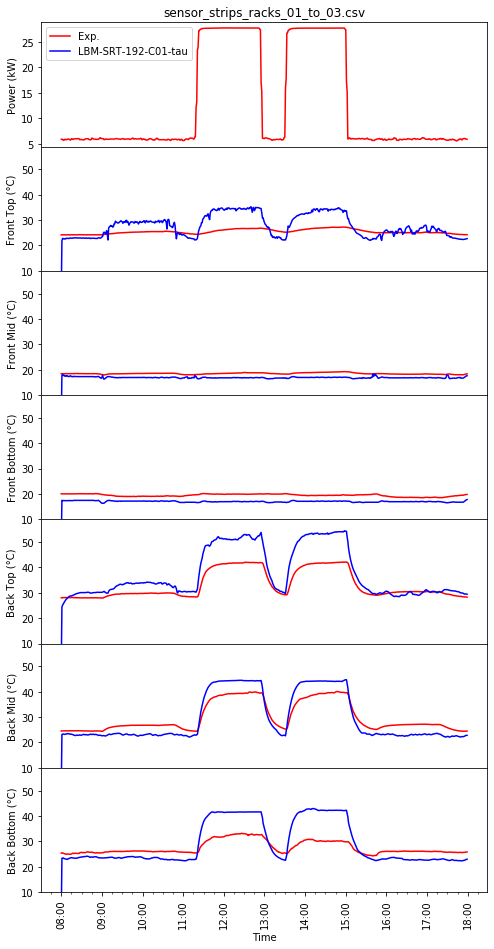

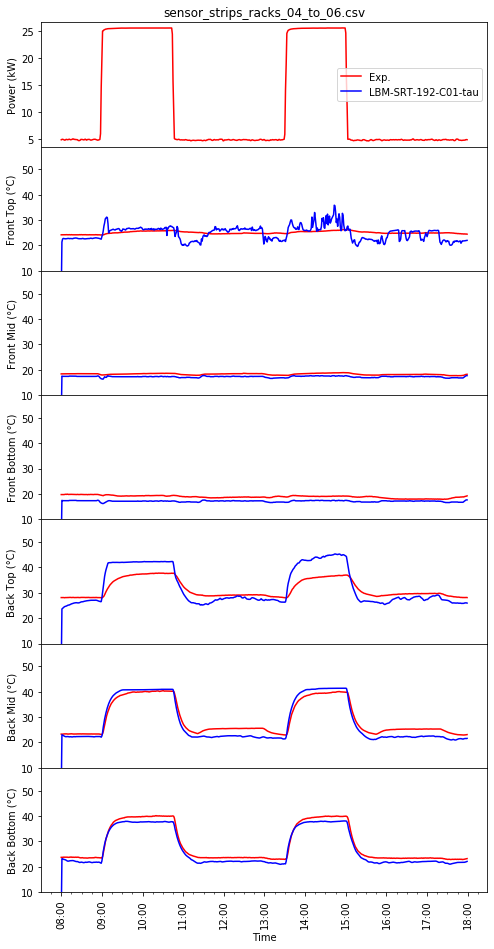

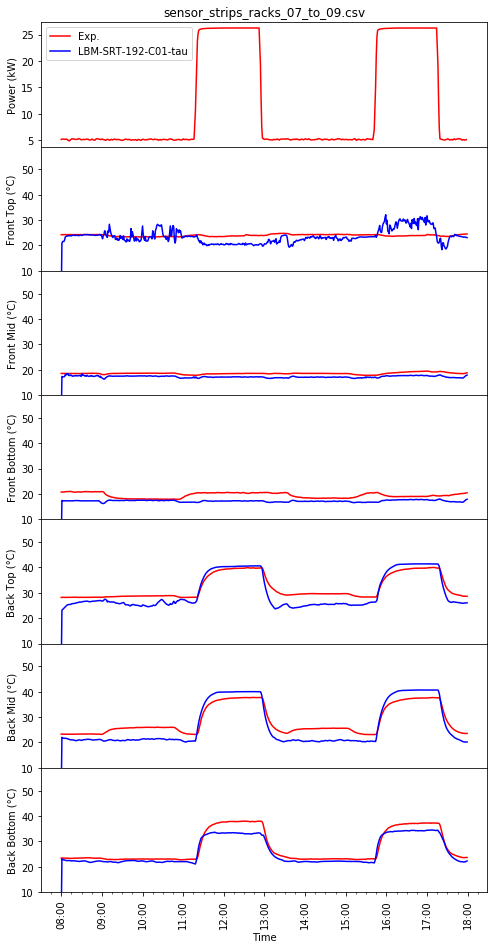

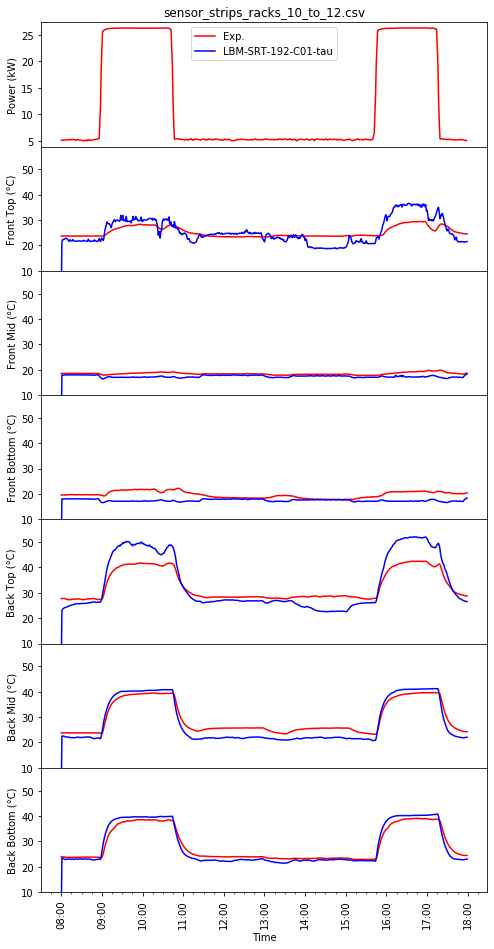

In [6]:
for rackId in range(0, 4):
    rack, xaxis, yaxes, ax, labels = result.plot_rack(rackId)
    for i in range(0, len(yaxes)):
        rack.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

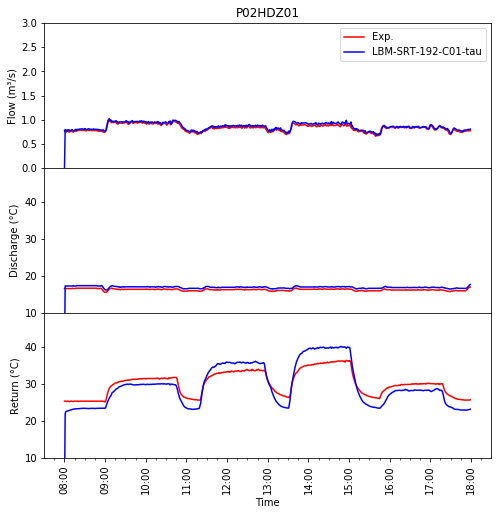

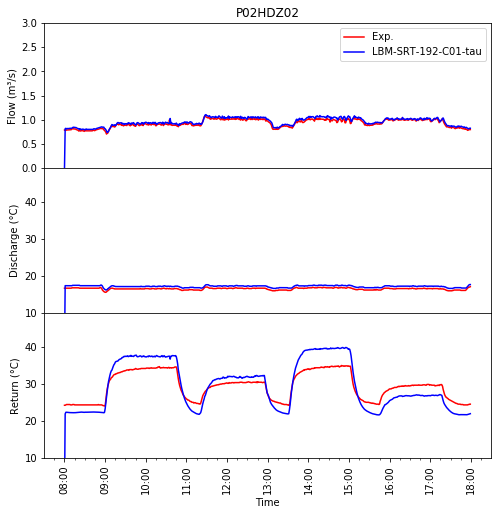

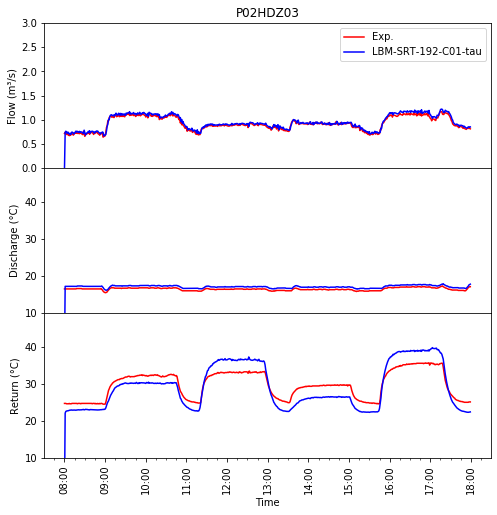

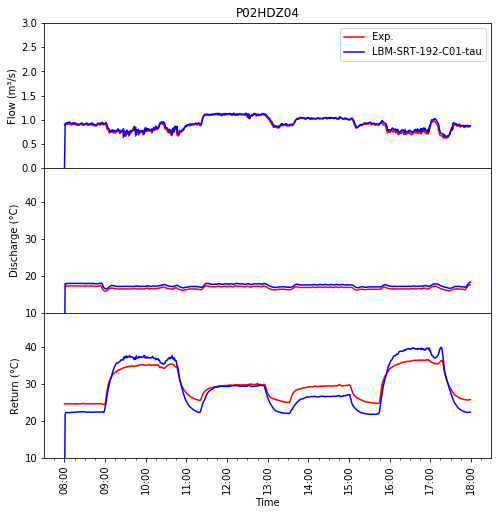

In [7]:
for coolerId in range(0, 4):
    cooler, xaxis, yaxes, ax, labels = result.plot_cooler(coolerId)
    for i in range(0, len(yaxes)):
        cooler.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

In [8]:
# result.get_racks_rmse('LBM-MRT-192')